# Zonal Statistics - continuous values

In [1]:
import glob, os
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterstats
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from IPython.display import display
import numpy as np

print('All libraries successfully imported!')
print(f'Rasterstats : {rasterstats.__version__}')

All libraries successfully imported!
Rasterstats : 0.14.0


In [2]:
import warnings
warnings.filterwarnings("ignore")

print("BE CAREFULL warning are masked !!")

BE CAREFULL warning are masked !!


## Set parameters

Choose statistics :
- min
- max
- mean

In [4]:

nodata_val = -10000

start = '20200101'
end   = '20200601'

### Date
The date must be in each image filename. `begin_date` is the first position of the date

E.g. : "SITE_3_**2**0181108_NDVI.tif" --> **begin_date = 8**

In [3]:
format     = '%Y%m%d' # format : YYYYMMDD
begin_date = 8

## Set directory

In [29]:

# Directory for all work files
work_path = f'/export/miro/students/bnorgaard/Backup_training_data/'


# Rasters files directory
raster_file_list = sorted(glob.glob(f'{work_path}images/Subset_S2A_MSIL2A_20200407T104021_N0214_R008_T31UFS_20200407T113125_resampled_BandMath.data/*.img'))

raster_file_list = sorted(glob.glob(f'{work_path}images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/*.img'))


print(raster_file_list)
# Vector file
vector_file  = f'{work_path}shp/invariant_shp/invariant_surfaces.shp'

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'


Path(zonal_stat_path).mkdir(parents=True, exist_ok=True)

['/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B2.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B3.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B4.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/B8.img', '/export/miro/students/bnorgaard/Backup_training_data/images/Subset_S2A_MSIL2A_20201106T105241_N0214_R051_T31UFS_20201106T134121_resampled_BandMath.data/lai.img']


## Check if raster and vector are projected to the same CRS

In [14]:
gdf = gpd.read_file(vector_file)
src = rasterio.open(raster_file_list[0], "r")

crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

We must reproject vector file


**Check if raster and vector file are intersecting**

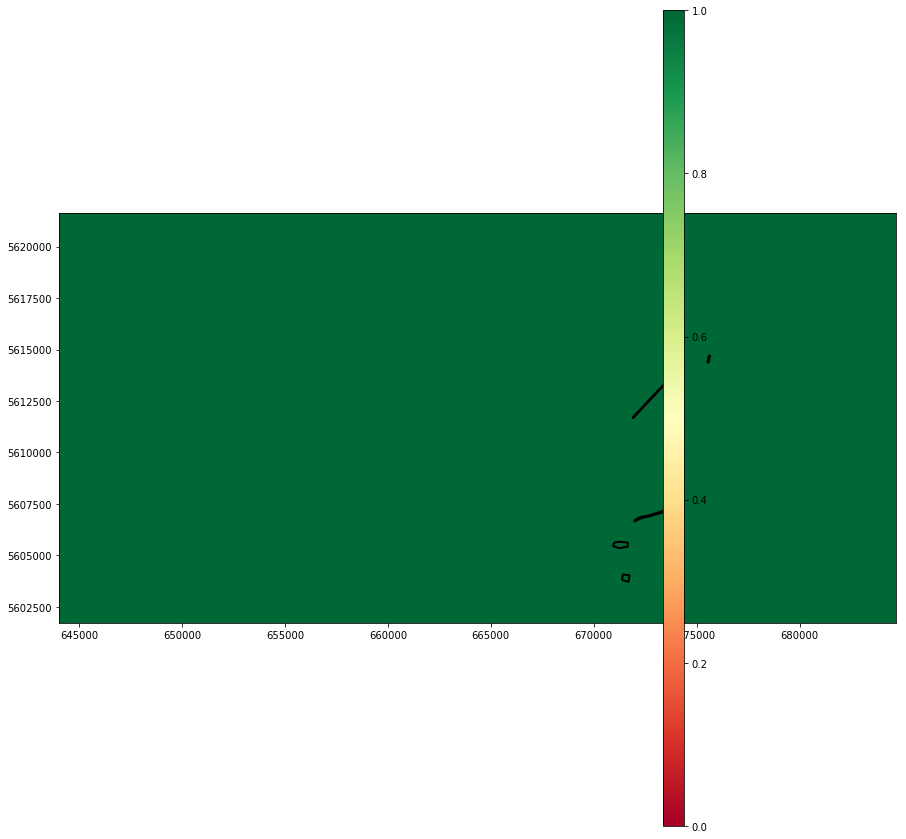

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

# Plot vector
gdf.plot(facecolor='none', edgecolor='black', linewidth = 2, ax=ax)

# Plot image
color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

src = rasterio.open(raster_file_list[2], "r")
im_rio = rasterio.plot.show(src, cmap=color_map, vmin=0, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)


plt.box(False)

In [17]:
gdf["id"] = gdf.index

display(gdf)

,id,TYPE,geometry
0,0,quarry,"POLYGON ((670994.030 5605621.100, 671284.291 5..."
1,1,water,"POLYGON ((673420.000 5607178.563, 673448.220 5..."
2,2,warehouse roof,"POLYGON ((675595.072 5614716.763, 675651.630 5..."
3,3,pine trees,"POLYGON ((671377.412 5603807.503, 671411.010 5..."
4,4,airport_track,"POLYGON ((671884.400 5611693.025, 673419.840 5..."


## Get date of each image

In [30]:
dict_list = []

for im in raster_file_list:
            
        date_str = 'B' + os.path.basename(im)[1:2]
        
        print(date_str)

        dict_list.append({'date': date_str,
                            'im_path': im})

im_date_path_df = pd.DataFrame.from_dict(dict_list).sort_values('date')

display(im_date_path_df)

B2
B3
B4
B8
Ba


,date,im_path
0,B2,/export/miro/students/bnorgaard/Backup_trainin...
1,B3,/export/miro/students/bnorgaard/Backup_trainin...
2,B4,/export/miro/students/bnorgaard/Backup_trainin...
3,B8,/export/miro/students/bnorgaard/Backup_trainin...
4,Ba,/export/miro/students/bnorgaard/Backup_trainin...


### Select images inside a period

## Compute zonal statistics

In [12]:
def mean_div_std(x):

    mean = np.mean(x)
    std  = np.std(x)

    result = mean / std

    return result

In [33]:
df_list = []
date_list = []

for i, row in im_date_path_df.iterrows():
    im_file    = row['im_path']
    date  = row['date']
    
    # Open GeoTIFF file
    src = rasterio.open(im_file, 'r')
    im_arr = src.read(1)
    
    # Change NaN by "nodata_val"
    im_arr = np.nan_to_num(im_arr, nan=nodata_val)

    # Get transform from profile (metadata)
    profile = src.profile
    transform = profile['transform']
    
    src.close()

    df = pd.DataFrame(zonal_stats(gdf,
                                  im_arr,
                                  affine=transform,
                                  stats=['mean'],
                                  nodata=nodata_val))
    
    df = df.rename(columns={'mean': f'mean__{date}'})
    
    df_list.append(df)
    

dfs = pd.concat(df_list, axis=1).divide(10000)

display(dfs)
display(gdf)


,mean__B2,mean__B3,mean__B4,mean__B8,mean__Ba
0,0.024499,0.034038,0.037920,0.058099,0.000037
1,0.011120,0.024980,0.020095,0.013518,0.000025
2,0.265435,0.294877,0.316177,0.335580,0.000018
3,0.005833,0.028233,0.029132,0.190367,0.000128
4,0.058782,0.071210,0.079812,0.117712,0.000005


,id,TYPE,geometry
0,0,quarry,"POLYGON ((670994.030 5605621.100, 671284.291 5..."
1,1,water,"POLYGON ((673420.000 5607178.563, 673448.220 5..."
2,2,warehouse roof,"POLYGON ((675595.072 5614716.763, 675651.630 5..."
3,3,pine trees,"POLYGON ((671377.412 5603807.503, 671411.010 5..."
4,4,airport_track,"POLYGON ((671884.400 5611693.025, 673419.840 5..."


## Plot timeseries

In [15]:
df = dfs.filter(regex='mean')

display(df)

df['parcel_id'] = df.index

df = df.set_index('parcel_id')

df = df.transpose()

df['date'] = date_list


df = df.melt(id_vars=['date'], var_name='parcel_id')

df = df.merge(gdf, left_on='parcel_id', right_on='id')

df = df[['date','parcel_id','value','sub_nb','sub','class_nb','class']]

display(df)


,mean__16012020,mean__12022020,mean__16032020,mean__17042020,mean__20052020,mean__21062020,mean__19072020,mean__13082020,mean__14092020,mean__19102020,mean__18112020,mean__18122020
0,0.7395,0.1272,0.8413,0.8236,0.6891,0.7709,0.7815,0.4859,0.5481,0.6841,0.7976,0.7610
1,0.7475,NaN,0.7638,0.8128,0.7638,0.5150,0.7029,0.3949,0.6004,0.6972,0.7914,0.7185
2,0.7392,NaN,0.7566,0.5829,0.5943,0.7457,0.7798,0.5395,0.4648,0.5568,0.6331,0.6759
3,0.6598,0.6801,0.6979,0.8038,0.8918,0.7204,0.6554,0.6826,0.7663,0.8264,0.6573,0.6309
4,0.7268,NaN,0.7962,0.8004,0.5363,0.7735,0.8932,0.6061,0.5772,0.5625,0.8323,0.8127
...,...,...,...,...,...,...,...,...,...,...,...,...
728,NaN,0.3371,0.5573,0.6364,0.9057,0.6302,0.9453,0.8781,0.8661,0.8224,0.6595,0.5909
729,0.5909,0.1317,0.4802,0.6402,0.7913,0.5485,0.8005,0.7715,0.8120,0.7472,0.6570,0.5920
730,0.6248,0.2534,0.5915,NaN,0.8734,0.9049,0.9240,0.8966,0.8531,0.8123,0.6661,0.6007
731,0.2090,0.1992,0.1808,0.1673,0.1392,0.1767,0.1832,0.2076,0.1431,0.2825,0.2529,0.2505


,date,parcel_id,value,sub_nb,sub,class_nb,class
0,2020-01-16,0,0.7395,3199,Grassland and meadows,319,Grassland and meadows
1,2020-02-12,0,0.1272,3199,Grassland and meadows,319,Grassland and meadows
2,2020-03-16,0,0.8413,3199,Grassland and meadows,319,Grassland and meadows
3,2020-04-17,0,0.8236,3199,Grassland and meadows,319,Grassland and meadows
4,2020-05-20,0,0.6891,3199,Grassland and meadows,319,Grassland and meadows
...,...,...,...,...,...,...,...
8791,2020-08-13,732,0.1960,7211,Bare soils,721,Bare soils
8792,2020-09-14,732,0.1671,7211,Bare soils,721,Bare soils
8793,2020-10-19,732,0.2447,7211,Bare soils,721,Bare soils
8794,2020-11-18,732,0.2429,7211,Bare soils,721,Bare soils


In [12]:
fig = px.line(df,
              x='date',
              y='value',
              color='class_nb',
              line_group='parcel_id',
              hover_data=['sub_nb','sub'],
              title= 'title')

fig.show()

## Write output to shapefile

In [13]:
gdf_with_zonal_stat = pd.concat([gdf, dfs], axis=1, join="inner")

display(gdf_with_zonal_stat)

#gdf_with_zonal_stat.columns = gdf_with_zonal_stat.columns.astype(str)


gdf_with_zonal_stat.to_file(zonal_stat_shp)

print(f'SHP file was created : {zonal_stat_shp}')

,id,lc_nb,lc,grp_nb,grp,class_nb,class,sub_nb,sub,grp_1_nb,...,mean__18112020,valid_18112020,std___18112020,nan___18112020,mDIVs_18112020,mean__18122020,valid_18122020,std___18122020,nan___18122020,mDIVs_18122020
0,0,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.7976,25,0.0516,0,15.4615,0.7610,25,0.0409,0,18.6177
1,1,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.7914,26,0.0376,0,21.0200,0.7185,26,0.0311,0,23.0900
2,2,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.6331,27,0.1587,0,3.9892,0.6759,26,0.1439,1,4.6973
3,3,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.6573,88,0.0958,0,6.8626,0.6309,62,0.0733,26,8.6033
4,4,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.8323,206,0.0724,2,11.5005,0.8127,204,0.0597,4,13.6152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,727,6,Forest,69,Forest,699,Forest,6999,Forest,69,...,0.6595,15,0.0514,41,12.8283,0.5909,5,0.0741,51,7.9720
729,730,6,Forest,69,Forest,699,Forest,6999,Forest,69,...,0.6570,118,0.1176,18,5.5887,0.5920,68,0.0652,68,9.0778
730,731,6,Forest,69,Forest,699,Forest,6999,Forest,69,...,0.6661,96,0.0597,8,11.1671,0.6007,70,0.0541,34,11.1064
731,711,7,Bare soil,72,Bare soils,721,Bare soils,7211,Bare soils,72,...,0.2529,52,0.1161,0,2.1778,0.2505,52,0.0940,0,2.6662


SHP file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cont_NDVI.shp


## Write output to CSV

In [14]:
gdf_with_zonal_stat = pd.concat([gdf, dfs], axis=1, join="inner")

gdf_with_zonal_stat = gdf_with_zonal_stat.drop(columns='geometry')

display(gdf_with_zonal_stat)

gdf_with_zonal_stat.to_csv(zonal_stat_csv)

print(f'CSV file was created : {zonal_stat_csv}')

,id,lc_nb,lc,grp_nb,grp,class_nb,class,sub_nb,sub,grp_1_nb,...,mean__18112020,valid_18112020,std___18112020,nan___18112020,mDIVs_18112020,mean__18122020,valid_18122020,std___18122020,nan___18122020,mDIVs_18122020
0,0,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.7976,25,0.0516,0,15.4615,0.7610,25,0.0409,0,18.6177
1,1,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.7914,26,0.0376,0,21.0200,0.7185,26,0.0311,0,23.0900
2,2,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.6331,27,0.1587,0,3.9892,0.6759,26,0.1439,1,4.6973
3,3,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.6573,88,0.0958,0,6.8626,0.6309,62,0.0733,26,8.6033
4,4,3,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3199,Grassland and meadows,3,...,0.8323,206,0.0724,2,11.5005,0.8127,204,0.0597,4,13.6152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,727,6,Forest,69,Forest,699,Forest,6999,Forest,69,...,0.6595,15,0.0514,41,12.8283,0.5909,5,0.0741,51,7.9720
729,730,6,Forest,69,Forest,699,Forest,6999,Forest,69,...,0.6570,118,0.1176,18,5.5887,0.5920,68,0.0652,68,9.0778
730,731,6,Forest,69,Forest,699,Forest,6999,Forest,69,...,0.6661,96,0.0597,8,11.1671,0.6007,70,0.0541,34,11.1064
731,711,7,Bare soil,72,Bare soils,721,Bare soils,7211,Bare soils,72,...,0.2529,52,0.1161,0,2.1778,0.2505,52,0.0940,0,2.6662


CSV file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cont_NDVI.csv
